In [237]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
torch.manual_seed(1337)

BAYESIAN CNN

CNN's with prior probability distributions placed over a set of model parameters $\omega = \{W_1,\dots,W_L\}$ for $L$ layers, $\omega \sim p(\omega)$ Guassian prior

Likelihood model: $p(y=c | \mathbf{x}, \omega) = \text{softmax}(\textbf{f}^{\omega}(\textbf{x}))$

Inference is done by training a model with dropout before every weight layer

Perform dropout at test time as well to sample from the approximate posterior

"able to achieve 5% test error on MNIST with only 295 labelled images without relying on unlabelled data"

In [238]:
device = torch.device("mps") if torch.mps.is_available else "cpu"
train_mnist = datasets.MNIST('./data', train=True, download=True, transform=ToTensor())
test_mnist = datasets.MNIST('./data', train=False, transform=ToTensor())
train_mnist.__len__, test_mnist.__len__

(<bound method MNIST.__len__ of Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor()>,
 <bound method MNIST.__len__ of Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor()>)

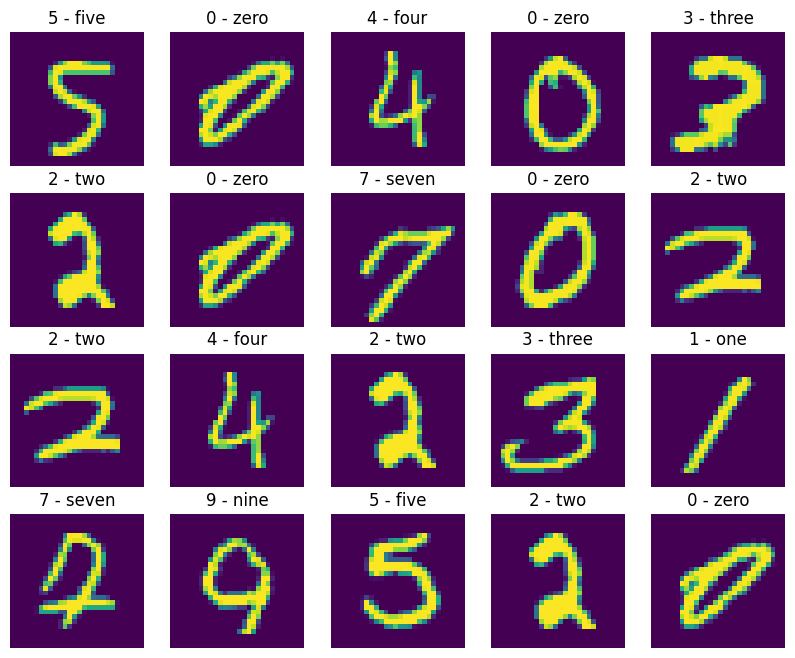

In [239]:
C = len(train_mnist.classes)
num_train = 20
# TODO: validation set

# TODO: make sure that sample without replacement and that no matches in train_set and val_set
train_subset, pool = torch.utils.data.random_split(train_mnist, [20, 60_000-20], generator=torch.Generator().manual_seed(1))
train_loader = DataLoader(dataset=train_subset, shuffle=True)
pool_loader = DataLoader(dataset=pool, shuffle=True)
test_loader = DataLoader(dataset=test_mnist)
N = len(train_loader)

fig = plt.figure(figsize=(10,8))
for i in range(num_train):
    img, label = next(iter(train_loader))
    img = img.squeeze()
    fig.add_subplot(4,5,i+1)
    plt.axis("off")
    plt.title(train_mnist.classes[label])
    plt.imshow(img)
plt.show()


# Figure 1 (old, go to bottom for new)

In [517]:
import pickle
from bayes_cnn import *
with open("../results/exp_res_random_acquisition_s16.pkl", "rb") as f:
  plotting_rand = pickle.load(f)
  
with open("../results/exp_k3_max_entropy_s3_DFalse_STD.pkl", "rb") as f:
  plotting_max_entropy = pickle.load(f)

with open("../results/exp_res_variation_ratio_s10.pkl", "rb") as f:
  plotting_variation_ratio = pickle.load(f)

with open("../results/exp_res_bald_s15.pkl", "rb") as f:
  plotting_bald = pickle.load(f)

with open("../results/exp_res_mean_std_s7.pkl", "rb") as f:
  plotting_mean_std = pickle.load(f)

In [518]:
from bayes_cnn import *
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.ticker as mticker

In [519]:
# fig, ax = plt.subplots(figsize=(6,4))
# t = np.arange(0, 1001, 10)
# fig.tight_layout()

# data_rand = torch.tensor(plotting_rand[random_acquisition], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
# data_mean_std = torch.tensor(plotting_mean_std[mean_std], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
# data_max_entropy = torch.tensor(plotting_max_entropy[max_entropy], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
# data_variation_ratio = torch.tensor(plotting_variation_ratio[variation_ratio], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
# data_bald = torch.tensor(plotting_bald[bald], dtype=torch.float32).view(3,101).mean(axis=0).tolist()

# print(len(data_rand), len(data_max_entropy))
# vals1 = [v/100 for v in data_rand]
# vals2 = [v/100 for v in data_max_entropy]
# vals3 = [v/100 for v in data_variation_ratio]
# vals4 = [v/100 for v in data_bald]
# vals5 = [v/100 for v in data_mean_std]

# p1 = ax.plot(t, vals1, label='random_acquisition') # SUMMARY acq_func=<function random_acquisition at 0x1269e3740>: 10% error: 296.6666666666667, 5% error: 863.3333333333334, TIME:20.593948702017467m
# p2 = ax.plot(t, vals2, label='max_entropy') # SUMMARY acq_func=<function max_entropy at 0x123be37f0>: 10% error: 223.33333333333334, 5% error: 420.0, TIME:282.1928124507268m
# p3 = ax.plot(t, vals3, label='variation_ratio') # SUMMARY acq_func=<function variation_ratio at 0x123fe38a0>: 10% error: 146.66666666666666, 5% error: 296.6666666666667, TIME:58.30369653304418m
# p4 = ax.plot(t, vals4, label='bald') # SUMMARY acq_func=<function bald at 0x117be3a00>: 10% error: 176.66666666666666, 5% error: 353.3333333333333, TIME:53.55837798515956m
# p5 = ax.plot(t, vals5, label='mean_std') # SUMMARY acq_func=<function mean_std at 0x1192e3950>: 10% error: 176.66666666666666, 5% error: 373.3333333333333, TIME:23.032434785366057m

# ax.legend(loc='lower right')
# ax.grid(linestyle='--')
# ax.set_ylim(bottom=80, top=100)
# ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
# ax.set_xticks(np.arange(0, 1001, 100))
# ax.set_xlim(left=0, right=1000)

# fig.savefig("fig1.png")
# plt.show()

# Figure 2

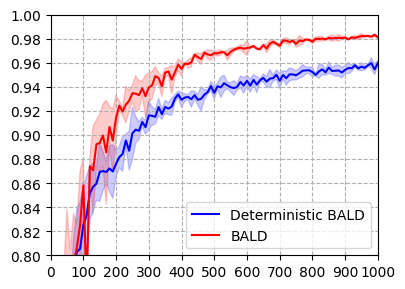

In [520]:
import numpy as np 
fig, ax = plt.subplots(figsize=(4,3))
t = np.arange(0, 1001, 10)
fig.tight_layout()

for d in ["True", "False"]:
  data_bald_l = []
  for i in range(1,4):
    with open(f"../results/exp_k3_bald_s{i}_d{d}_STD.pkl", "rb") as f:
      plotting_bald = pickle.load(f)
      data_bald_l.append(plotting_bald[bald])

  data_bald = torch.tensor(data_bald_l, dtype=torch.float32).view(3,101) / 10_000
  bald_mean = data_bald.mean(dim=0)
  bald_std = data_bald.std(dim=0)

  ax.plot(t, bald_mean, label="BALD" if d == "False" else "Deterministic BALD", color="red" if d == "False" else "blue")
  ax.fill_between(t, bald_mean - bald_std, bald_mean + bald_std, alpha=0.2, color="red" if d == "False" else "blue")
  ax.legend(loc='lower right')
  ax.grid(linestyle='--')
  ax.set_ylim(bottom=0.8, top=1)
  ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
  ax.set_xticks(np.arange(0, 1001, 100))
  ax.set_xlim(left=0, right=1000)

fig.savefig("figure2_bald.png")

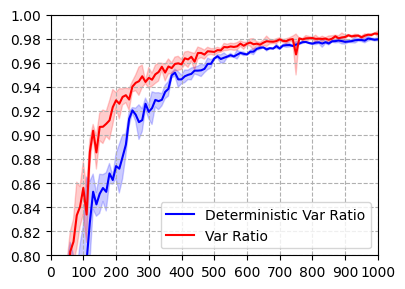

In [521]:
fig, ax = plt.subplots(figsize=(4,3))
t = np.arange(0, 1001, 10)
fig.tight_layout()

for d in ["True", "False"]:
  data_bald_l = []
  if d == "True":
    for i in range(2,5):
      with open(f"../results/exp_k3_variation_ratio_s{i}_d{d}_STD.pkl", "rb") as f:
        plotting_bald = pickle.load(f)
        data_bald_l.append(plotting_bald[variation_ratio])
  else:
    for i in range(4,7):
      with open(f"../results/exp_k3_variation_ratio_s{i}_d{d}_STD.pkl", "rb") as f:
        plotting_bald = pickle.load(f)
        data_bald_l.append(plotting_bald[variation_ratio])
    
  data_bald = torch.tensor(data_bald_l, dtype=torch.float32).view(3, 101) / 10_000

  bald_mean = data_bald.mean(dim=0)
  bald_std = data_bald.std(dim=0)

  ax.plot(t, bald_mean, label="Var Ratio" if d == "False" else "Deterministic Var Ratio", color="red" if d == "False" else "blue")
  ax.fill_between(t, bald_mean - bald_std, bald_mean + bald_std, alpha=0.2, color="red" if d == "False" else "blue")
  ax.legend(loc='lower right')
  ax.grid(linestyle='--')
  ax.set_ylim(bottom=0.8, top=1)
  ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
  ax.set_xticks(np.arange(0, 1001, 100))
  ax.set_xlim(left=0, right=1000)

fig.savefig("figure2_variation_ratio.png")

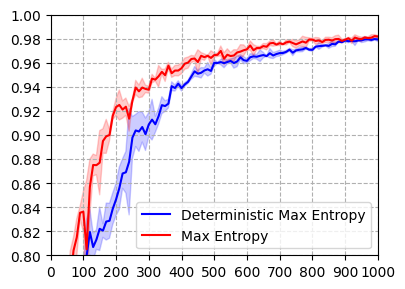

In [522]:
fig, ax = plt.subplots(figsize=(4,3))
t = np.arange(0, 1001, 10)
fig.tight_layout()

for i in range(1,7,3):
  # for d in ["True", "False"]:
  if i < 4: d = "True" 
  else: d = "False"
  data_max_entropy_l = []
  if d == "True":
    with open(f"../results/exp_k3_max_entropy_s4_d{d}_STD.pkl", "rb") as f:
      plotting_max_entropy = pickle.load(f)
      data_max_entropy_l.append(plotting_max_entropy[max_entropy])
  else:
    with open(f"../results/exp_k3_max_entropy_s4_d{d}_STD.pkl", "rb") as f:
      plotting_max_entropy = pickle.load(f)
      data_max_entropy_l.append(plotting_max_entropy[max_entropy])

  data_max_entropy = torch.tensor(data_max_entropy_l, dtype=torch.float32).view(3,101) / 10_000
  max_entropy_mean = data_max_entropy.mean(dim=0)
  max_entropy_std = data_max_entropy.std(dim=0)

  ax.plot(t, max_entropy_mean, label="Max Entropy" if d == "False" else "Deterministic Max Entropy", color="red" if d == "False" else "blue")
  ax.fill_between(t, max_entropy_mean - max_entropy_std, max_entropy_mean + max_entropy_std, alpha=0.2, color="red" if d == "False" else "blue")
  ax.legend(loc='lower right')
  ax.grid(linestyle='--')
  ax.set_ylim(bottom=0.8, top=1)
  ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
  ax.set_xticks(np.arange(0, 1001, 100))
  ax.set_xlim(left=0, right=1000)

fig.savefig("figure2_max_entropy.png")

# pt 2

In [523]:
with open("../results/exp_k3_all_s200_dFalse.pkl", "rb") as f:
  plotting = pickle.load(f)

In [524]:
plotting.keys()

dict_keys([<function random_acquisition at 0x1435f9220>, <function mean_std at 0x1435f9430>, <function max_entropy at 0x1435f92d0>, <function variation_ratio at 0x1435f9380>, <function bald at 0x1435f94e0>])

101 101


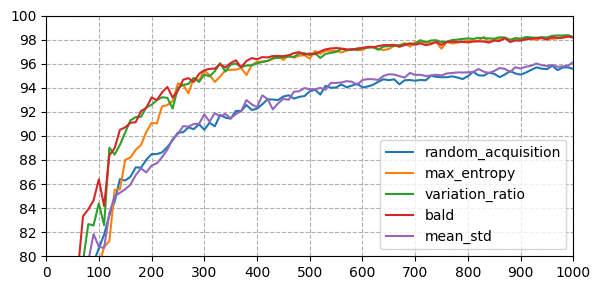

In [525]:
"""
device='mps', NUM_EPOCHS=50, NUM_ACQUIRE=10, NUM_CLASSES=10, BATCH_SIZE=128, SEED=200, NUM_SEEDS=3, T=100
100%|████████████████████████████████████████████████████████████████| 100/100 [16:01<00:00,  9.61s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [16:11<00:00,  9.72s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [16:08<00:00,  9.68s/it]
SUMMARY acq_func=<function random_acquisition at 0x1124df7f0>: 10% error: 256.6666666666667, 5% error: 670.0, TIME:48.78630918264389m
100%|████████████████████████████████████████████████████████████████| 100/100 [19:13<00:00, 11.54s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [18:50<00:00, 11.30s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [19:05<00:00, 11.46s/it]
SUMMARY acq_func=<function mean_std at 0x1124dfa00>: 10% error: 243.33333333333334, 5% error: 640.0, TIME:57.56855080127716m
100%|████████████████████████████████████████████████████████████████| 100/100 [19:16<00:00, 11.56s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [19:07<00:00, 11.48s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [19:18<00:00, 11.59s/it]
SUMMARY acq_func=<function max_entropy at 0x1124df8a0>: 10% error: 180.0, 5% error: 290.0, TIME:58.11494816939036m
100%|████████████████████████████████████████████████████████████████| 100/100 [19:21<00:00, 11.62s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [19:18<00:00, 11.59s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [19:20<00:00, 11.61s/it]
SUMMARY acq_func=<function variation_ratio at 0x1124df950>: 10% error: 153.33333333333334, 5% error: 296.6666666666667, TIME:58.42545129855474m
100%|████████████████████████████████████████████████████████████████| 100/100 [19:20<00:00, 11.61s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [21:24<00:00, 12.84s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [19:15<00:00, 11.56s/it]
SUMMARY acq_func=<function bald at 0x1124dfab0>: 10% error: 143.33333333333334, 5% error: 276.6666666666667, TIME:60.418639500935875m
"""

fig, ax = plt.subplots(figsize=(6,3))
t = np.arange(0, 1001, 10)
fig.tight_layout()

data_rand = torch.tensor(plotting[random_acquisition], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
data_mean_std = torch.tensor(plotting[mean_std], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
data_max_entropy = torch.tensor(plotting[max_entropy], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
data_variation_ratio = torch.tensor(plotting[variation_ratio], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
data_bald = torch.tensor(plotting[bald], dtype=torch.float32).view(3,101).mean(axis=0).tolist()

print(len(data_rand), len(data_max_entropy))
vals1 = [v/100 for v in data_rand]
vals2 = [v/100 for v in data_max_entropy]
vals3 = [v/100 for v in data_variation_ratio]
vals4 = [v/100 for v in data_bald]
vals5 = [v/100 for v in data_mean_std]

p1 = ax.plot(t, vals1, label='random_acquisition') 
p2 = ax.plot(t, vals2, label='max_entropy') 
p3 = ax.plot(t, vals3, label='variation_ratio') 
p4 = ax.plot(t, vals4, label='bald') 
p5 = ax.plot(t, vals5, label='mean_std') 

ax.legend(loc='lower right')
ax.grid(linestyle='--')
ax.set_ylim(bottom=80, top=100)
ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
ax.set_xticks(np.arange(0, 1001, 100))
ax.set_xlim(left=0, right=1000)

fig.savefig("fig1.png")
plt.show()

In [526]:
# fig, ax = plt.subplots(figsize=(4,3))
# t = np.arange(0, 1001, 10)
# fig.tight_layout()

# for d in ["False", "True"]:
#   data_bald_l = []
#   if d == "False":
#     data_bald_l = plotting[bald]
#   else:
#     for i in range(33,36):
#       with open(f"../exp_k3_bald_s{i}_dTrue_STD_v2.pkl", "rb") as f:
#         pkl_data = pickle.load(f)
#         data_bald_l.append(pkl_data[bald])

#   data_bald = torch.tensor(data_bald_l, dtype=torch.float32).view(3,101) / 10_000
#   bald_mean = data_bald.mean(dim=0)
#   bald_std = data_bald.std(dim=0)

#   ax.plot(t, bald_mean, label="BALD" if d == "False" else "Deterministic BALD", color="red" if d == "False" else "blue")
#   ax.fill_between(t, bald_mean - bald_std, bald_mean + bald_std, alpha=0.2, color="red" if d == "False" else "blue")
#   ax.legend(loc='lower right')
#   ax.grid(linestyle='--')
#   ax.set_ylim(bottom=0.8, top=1)
#   ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
#   ax.set_xticks(np.arange(0, 1001, 100))
#   ax.set_xlim(left=0, right=1000)

# fig.savefig("figure2_bald.png")

In [527]:
# fig, ax = plt.subplots(figsize=(4,3))
# t = np.arange(0, 1001, 10)
# fig.tight_layout()

# for d in ["True", "False"]:
#   data_var_ratio_l = []
#   if d == "False":
#     data_var_ratio_l = plotting[variation_ratio]
#   else:
#     for i in range(6,9):
#       with open(f"../exp_k3_variation_ratio_s{i}_dTrue_STD_v2.pkl", "rb") as f:
#         pkl_data = pickle.load(f)
#         data_var_ratio_l.append(pkl_data[variation_ratio])

#   data_var_ratio = torch.tensor(data_var_ratio_l, dtype=torch.float32).view(3, 101) / 10_000

#   var_ratio_mean = data_var_ratio.mean(dim=0)
#   var_ratio_std = data_var_ratio.std(dim=0)

#   ax.plot(t, var_ratio_mean, label="Var Ratio" if d == "False" else "Deterministic Var Ratio", color="red" if d == "False" else "blue")
#   ax.fill_between(t, var_ratio_mean - var_ratio_std, var_ratio_mean + var_ratio_std, alpha=0.2, color="red" if d == "False" else "blue")
#   ax.legend(loc='lower right')
#   ax.grid(linestyle='--')
#   ax.set_ylim(bottom=0.8, top=1)
#   ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
#   ax.set_xticks(np.arange(0, 1001, 100))
#   ax.set_xlim(left=0, right=1000)

# fig.savefig("figure2_variation_ratio.png")

In [528]:
# fig, ax = plt.subplots(figsize=(4,3))
# t = np.arange(0, 1001, 10)
# fig.tight_layout()

# for d in ["True", "False"]:
#   data_max_entropy_l = []
#   if d == "False":
#     data_max_entropy_l = plotting[max_entropy]
#   else:
#     for i in range(41,44):
#       with open(f"../exp_k3_max_entropy_s{i}_dTrue_STD_v2.pkl", "rb") as f:
#         plotting_max_entropy = pickle.load(f)
#         data_max_entropy_l.append(plotting_max_entropy[max_entropy])

#   data_max_entropy = torch.tensor(data_max_entropy_l, dtype=torch.float32).view(3,101) / 10_000
#   max_entropy_mean = data_max_entropy.mean(dim=0)
#   max_entropy_std = data_max_entropy.std(dim=0)

#   ax.plot(t, max_entropy_mean, label="Max Entropy" if d == "False" else "Deterministic Max Entropy", color="red" if d == "False" else "blue")
#   ax.fill_between(t, max_entropy_mean - max_entropy_std, max_entropy_mean + max_entropy_std, alpha=0.2, color="red" if d == "False" else "blue")
#   ax.legend(loc='lower right')
#   ax.grid(linestyle='--')
#   ax.set_ylim(bottom=0.8, top=1)
#   ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
#   ax.set_xticks(np.arange(0, 1001, 100))
#   ax.set_xlim(left=0, right=1000)

# fig.savefig("figure2_max_entropy.png")

## Min extension plot

In [529]:
"""
(venv) ➜  UDL git:(main) ✗ python3 mini-project/analytic.py --a analytic
device='mps', args.a='analytic', NUM_ACQUIRE=10, NUM_CLASSES=10, SEED=0, NUM_SEEDS=3, sigma2=1.0, s2=1.0
100%|████████████████████████████████████████████████████████████████| 100/100 [09:18<00:00,  5.59s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [09:21<00:00,  5.61s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [09:23<00:00,  5.63s/it]
SUMMARY args.a='analytic': final_mean_rmse=0.136852, TIME:28.087744053204855m
(venv) ➜  UDL git:(main) ✗ python3 mini-project/analytic.py --a mfvi    
device='mps', args.a='mfvi', NUM_ACQUIRE=10, NUM_CLASSES=10, SEED=0, NUM_SEEDS=3, sigma2=1.0, s2=1.0
100%|████████████████████████████████████████████████████████████████| 100/100 [09:04<00:00,  5.44s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [15:26<00:00,  9.26s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [09:10<00:00,  5.51s/it]
SUMMARY args.a='mfvi': final_mean_rmse=0.186374, TIME:33.71911205450694m
"""

"\n(venv) ➜  UDL git:(main) ✗ python3 mini-project/analytic.py --a analytic\ndevice='mps', args.a='analytic', NUM_ACQUIRE=10, NUM_CLASSES=10, SEED=0, NUM_SEEDS=3, sigma2=1.0, s2=1.0\n100%|████████████████████████████████████████████████████████████████| 100/100 [09:18<00:00,  5.59s/it]\n100%|████████████████████████████████████████████████████████████████| 100/100 [09:21<00:00,  5.61s/it]\n100%|████████████████████████████████████████████████████████████████| 100/100 [09:23<00:00,  5.63s/it]\nSUMMARY args.a='analytic': final_mean_rmse=0.136852, TIME:28.087744053204855m\n(venv) ➜  UDL git:(main) ✗ python3 mini-project/analytic.py --a mfvi    \ndevice='mps', args.a='mfvi', NUM_ACQUIRE=10, NUM_CLASSES=10, SEED=0, NUM_SEEDS=3, sigma2=1.0, s2=1.0\n100%|████████████████████████████████████████████████████████████████| 100/100 [09:04<00:00,  5.44s/it]\n100%|████████████████████████████████████████████████████████████████| 100/100 [15:26<00:00,  9.26s/it]\n100%|████████████████████████████████

/var/folders/94/dl4m80qj1lqcmcyl4dn8q1yw0000gn/T/ipykernel_18206/3688739770.py:23: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  bald_std = data_bald.std(dim=0)


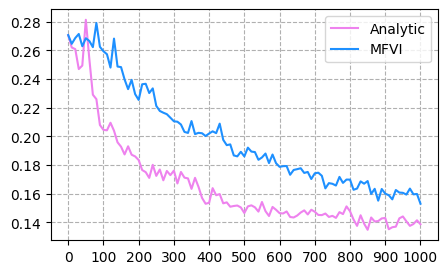

In [530]:
fig, ax = plt.subplots(figsize=(5,3))
t = np.arange(0, 1001, 10)
# fig.tight_layout()
"""
(venv) ➜  UDL git:(main) ✗ python3 mini-project/analytic.py --a mfvi
device='mps', args.a='mfvi', NUM_ACQUIRE=10, NUM_CLASSES=10, SEED=10, NUM_SEEDS=1, sigma2=1.0, s2=1.0
100%|████████████████████████████████████████████████████████████████| 100/100 [09:29<00:00,  5.70s/it]
SUMMARY args.a='mfvi': final_mean_rmse=0.153039, TIME:9.510247782866161m
(venv) ➜  UDL git:(main) ✗ python3 mini-project/analytic.py --a analytic
device='mps', args.a='analytic', NUM_ACQUIRE=10, NUM_CLASSES=10, SEED=10, NUM_SEEDS=1, sigma2=1.0, s2=1.0
100%|████████████████████████████████████████████████████████████████| 100/100 [15:34<00:00,  9.35s/it]
SUMMARY args.a='analytic': final_mean_rmse=0.138725, TIME:15.595296434561412m
"""

for a in ["Analytic", "MFVI"]:
  data_bald_l = []
  with open(f"../results/frozen_{a}_new_s10.pkl", "rb") as f:
    pkl_data = pickle.load(f)
    data_bald_l.append(pkl_data[str(a).lower()]['rmse'])

  data_bald = torch.tensor(data_bald_l, dtype=torch.float32).view(1,101) #/ 10_000
  bald_mean = data_bald.mean(dim=0)
  bald_std = data_bald.std(dim=0)

  ax.plot(t, bald_mean, label=a, color="violet" if a == "Analytic" else "dodgerblue")
  # ax.fill_between(t, bald_mean - bald_std, bald_mean + bald_std, alpha=0.2, color="green" if a == "Analytic" else "dodgerblue")
  ax.legend(loc='upper right')
  ax.grid(linestyle='--')
  ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
  ax.set_xticks(np.arange(0, 1001, 100))

fig.savefig("figure_analytic_new.png")

101 101


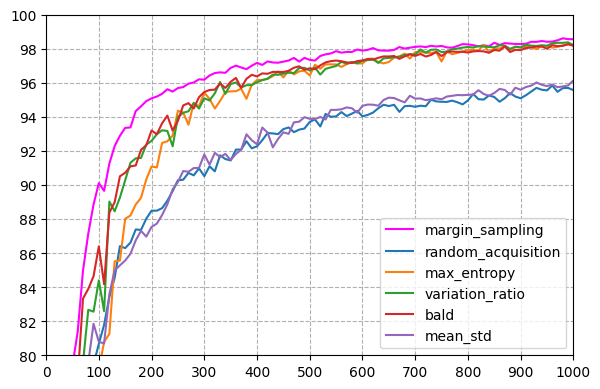

In [531]:

fig, ax = plt.subplots(figsize=(6,4))
t = np.arange(0, 1001, 10)
fig.tight_layout()


"""
(venv) ➜  UDL git:(main) ✗ python3 mini-project/novel3.py --a margin_sampling
device='mps', NUM_EPOCHS=50, NUM_ACQUIRE=10, NUM_CLASSES=10, BATCH_SIZE=128, SEED=1, NUM_SEEDS=3, T=100
100%|████████████████████████████████████████████████████████████████| 100/100 [20:52<00:00, 12.52s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [20:47<00:00, 12.48s/it]
100%|████████████████████████████████████████████████████████████████| 100/100 [20:44<00:00, 12.45s/it]
SUMMARY acq_func=<function margin_sampling at 0x10cee7740>: 10% error: 110.0, 5% error: 203.33333333333334, TIME:62.8675638516744m
"""
from novel3 import margin_sampling
with open("../results/NO_RETRAIN_NOVEL_exp_k3_margin_sampling_s1_dFalse_STD.pkl", "rb") as f:
  plotting = pickle.load(f)

data_qbc = torch.tensor(plotting[margin_sampling], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
vals6 = [v/100 for v in data_qbc]
p6 = ax.plot(t, vals6, label='margin_sampling', color="magenta")

with open("../results/exp_k3_all_s200_dFalse.pkl", "rb") as f:
  plotting = pickle.load(f)
from bayes_cnn import random_acquisition, mean_std, max_entropy, variation_ratio
data_rand = torch.tensor(plotting[random_acquisition], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
data_mean_std = torch.tensor(plotting[mean_std], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
data_max_entropy = torch.tensor(plotting[max_entropy], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
data_variation_ratio = torch.tensor(plotting[variation_ratio], dtype=torch.float32).view(3,101).mean(axis=0).tolist()
data_bald = torch.tensor(plotting[bald], dtype=torch.float32).view(3,101).mean(axis=0).tolist()

print(len(data_rand), len(data_max_entropy))
vals1 = [v/100 for v in data_rand]
vals2 = [v/100 for v in data_max_entropy]
vals3 = [v/100 for v in data_variation_ratio]
vals4 = [v/100 for v in data_bald]
vals5 = [v/100 for v in data_mean_std]

p1 = ax.plot(t, vals1, label='random_acquisition') 
p2 = ax.plot(t, vals2, label='max_entropy') 
p3 = ax.plot(t, vals3, label='variation_ratio') 
p4 = ax.plot(t, vals4, label='bald') 
p5 = ax.plot(t, vals5, label='mean_std') 



ax.legend(loc='lower right')
ax.grid(linestyle='--')
ax.set_ylim(bottom=80, top=100)
ax.yaxis.set_major_locator(mticker.MaxNLocator(10))
ax.set_xticks(np.arange(0, 1001, 100))
ax.set_xlim(left=0, right=1000)

fig.savefig("fig1_margin_sampling.png")
plt.show()